## Import library

In [1]:
%run bert
%run utils.ipynb
%run feat

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import linear_model 
from sklearn.metrics import cohen_kappa_score,mean_absolute_error,mean_squared_error,accuracy_score,explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna

### For plotting

In [2]:
sns.set_theme(style='darkgrid')

## Load Data

In [3]:
loader = DataLoader()
d = loader.GetData('L2Writing')
d.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [7]:
d[['syntax','vocabulary','phraseology','grammar','conventions']].describe()

,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000


In [8]:
tcount = []
i=0
for e in d['full_text']:
    i+= 1
    if i %100 == 0:
        print(i)
    ext = extractor.pass_text(e)
    f = ext.preprocess()
    tcount.append(f['n_token'])

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


In [9]:
d['token'] = tcount
d['token'].describe()

count    3911.000000
mean      333.484019
std       147.754908
min        12.000000
25%       228.500000
50%       311.000000
75%       408.000000
max       955.000000
Name: token, dtype: float64

<AxesSubplot: xlabel='token', ylabel='Count'>

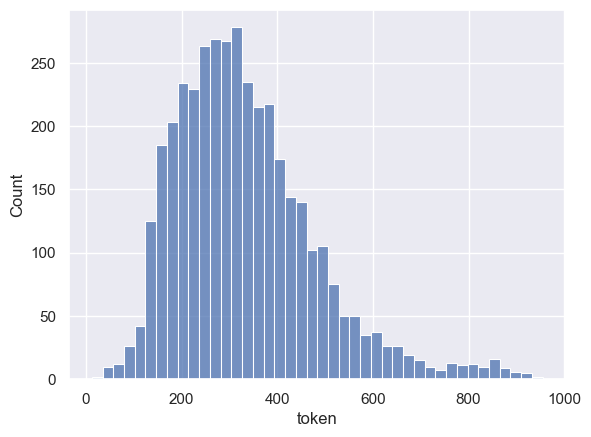

In [18]:
sns.histplot(d['token'])

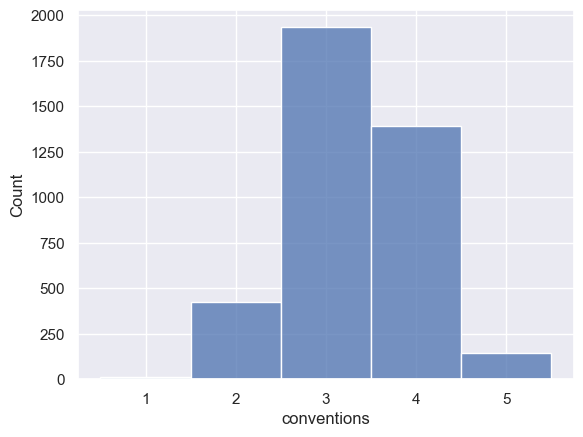

In [22]:
g = sns.histplot(d['conventions'],discrete=True)

## Model Inference

25m19.4s

In [4]:
EmbeddingFetcher = GetBERTEmbeddings(d['full_text'],'model/deberta-v3-large')
EmbeddingFetcher.inf(stop=1500,SeqLen = 512 )

tokenized
0/1500, run:0
10/1500, run:0
20/1500, run:0
30/1500, run:0
40/1500, run:0
50/1500, run:0
60/1500, run:0
70/1500, run:0
80/1500, run:0
90/1500, run:0
100/1500, run:0
110/1500, run:0
120/1500, run:0
130/1500, run:0
140/1500, run:0
150/1500, run:0
160/1500, run:0
170/1500, run:0
180/1500, run:0
190/1500, run:0
200/1500, run:0
210/1500, run:0
220/1500, run:0
230/1500, run:0
240/1500, run:0
250/1500, run:0
260/1500, run:0
270/1500, run:0
280/1500, run:0
290/1500, run:0
300/1500, run:0
310/1500, run:0
320/1500, run:0
330/1500, run:0
340/1500, run:0
350/1500, run:0
360/1500, run:0
370/1500, run:0
380/1500, run:0
390/1500, run:0
400/1500, run:0
410/1500, run:0
420/1500, run:0
430/1500, run:0
440/1500, run:0
450/1500, run:0
460/1500, run:0
470/1500, run:0
480/1500, run:0
490/1500, run:0
500/1500, run:0
510/1500, run:0
520/1500, run:0
530/1500, run:0
540/1500, run:0
550/1500, run:0
560/1500, run:0
570/1500, run:0
580/1500, run:0
590/1500, run:0
600/1500, run:0
610/1500, run:0
620/1500,

### Clear cuda cache

In [23]:
del EmbeddingFetcher.model
torch.cuda.empty_cache()

## Extract Embeddings

In [55]:
x = EmbeddingFetcher.GetEmbeddings('MeanP')

## Split Train and Test data

In [59]:
ind = [i for i in range(3911)]
ind = shuffle(ind)
trainIn,testIn = ind[:3100],ind[3100:]

In [69]:
x = [np.array(i).reshape(1024) for i in x]
columns = ['cohesion', 'syntax', 'vocabulary','phraseology', 'grammar', 'conventions']
TrainX,TestX = [x[i] for i in trainIn],[x[i] for i in testIn]

In [61]:
TrainY,TestY = [],[]
for i in columns:
    TrainY.append(d[i].iloc[trainIn])
    TestY.append(d[i].iloc[testIn])

## Hyper parameter tuning

In [ ]:
def objective(trial):
    params = {"random_state":trial.suggest_categorical("random_state", [42]),           
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1),  
        "max_depth" : trial.suggest_int("max_depth", 5, 15),
        "alpha" : trial.suggest_float('alpha',0.9,1),
    }
    error = []
    for i in range(6):
        model = xgb.XGBRegressor(**params)
        model.fit(TrainX,TrainY[i])
        PredY = model.predict(TestX)
        e = mean_squared_error(TestY[i],PredY,squared=False)
        error.append(e)
    mcrmse = sum(error)/6
    return mcrmse
#study = optuna.create_study()
#study.optimize(objective, n_trials=100) 

In [ ]:
from optuna.visualization.matplotlib import plot_optimization_history
#plot_optimization_history(study)

## No tuning

In [71]:
def objective():
    mlist = []
    error = []
    aberror = []
    for i in range(6):
        model = xgb.XGBRegressor(tree_method="hist",learning_rate=0.042)
        model.fit(TrainX,TrainY[i])
        PredY = model.predict(TestX)
        e = mean_squared_error(TestY[i],PredY,squared=False)
        ae = mean_absolute_error(TestY[i],PredY)
        error.append(e)
        aberror.append(ae)
        mlist.append(model)
    mcrmse = sum(error)/6
    mmae = sum(aberror)/6
    return [mcrmse,error,mmae,aberror],mlist


In [70]:
res = objective()
res[0]

[0.4901127988767116,
 [0.5189144681316188,
  0.48164353903948215,
  0.45622084121633005,
  0.49302976424567607,
  0.499472407159096,
  0.4913957734680665],
 0.38971831153755176,
 [0.41634049030473286,
  0.3854310790354756,
  0.3589799191008073,
  0.3938603920060521,
  0.3974893684010911,
  0.38620862037715137]]

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

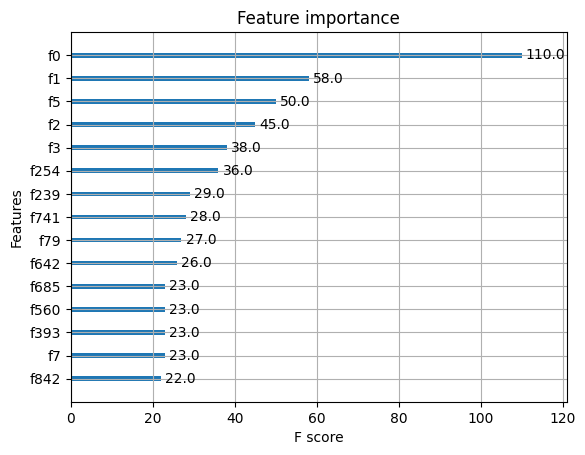

In [58]:
xgb.plot_importance(res[1][2],max_num_features=15)

## Features only

In [ ]:
spacy.prefer_gpu = False
spacy.prefer_gpu

False

767m48.5s

In [ ]:
x1 = []
c= 0
for essay in d['full_text']:
    ext = FeatureExtraction(essay)
    i = ext.GetFine()
    c += 1
    x1.append(i)
    if c % 10 == 0:
        print(c)
    with open('a.txt','a') as f:
        f.write(','.join([str(f) for f in i]))
        f.write('\n')
x1[0]

In [64]:
x1 = []
with open('a.txt') as f:
    for l in f.readlines():
        feat = [float(i) for i in l.split(',')]
        x1.append(feat)

In [65]:
TrainX,TestX = [x[i] for i in trainIn],[x[i] for i in testIn]

In [36]:
res = objective()
res[0]

([0.6566103741152405,
  [0.6742114618951561,
   0.6491155070637221,
   0.5811288459420132,
   0.647390551599236,
   0.7198891145851979,
   0.6679267636061174],
  0.5312721166304978,
  [0.5487662422965693,
   0.5133060041985,
   0.4682672558818587,
   0.5291697493904763,
   0.5952096094185563,
   0.532913838597026]],
 [XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.042, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
               num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             

## Features+embeddings

In [66]:
x2 = []
for i in range(3911):
    a = np.concatenate((x[i],x1[i]))
    x2.append(a)
TrainX,TestX = [x[i] for i in trainIn],[x[i] for i in testIn]

In [67]:
res = objective()
res[0]

[0.46874437043095823,
 [0.4997165420457511,
  0.4629332935223624,
  0.43024884420963827,
  0.4726074528138384,
  0.4834400040067978,
  0.46352008598736155],
 0.3731959862714925,
 [0.40033280614272,
  0.37067794505823703,
  0.33788423017861663,
  0.37759669141616536,
  0.38716116316074506,
  0.3655230816724709]]

## L2

In [52]:
with open('b1.txt') as f:
    l2 = f.readlines()
xl = dict()
for l in l2:
    i = int(l.split(',')[0].split('.')[0])
    feat = l.rstrip('\n').split(',')[-14:]
    feat = [float(s) for s in feat]
    xl[i] = feat
x4 = []
for i in range(3911):
    x4.append(xl[i])

In [53]:
TrainX,TestX = x4[:3100],x4[3100:]

In [54]:
res = objective()
res[0]

[0.6163962719820254,
 [0.6397027154083018,
  0.5849239355886143,
  0.5589177689471,
  0.6086826307275333,
  0.6881419588661435,
  0.6180086223544601],
 0.4983672518520457,
 [0.5201878422726538,
  0.4727889631591214,
  0.4343680009594975,
  0.4977107791806561,
  0.568865179721583,
  0.4962827458187625]]

In [44]:
x5 = []
for i in range(3911):
    a = np.concatenate((x[i],x4[i]))
    x5.append(a)
TrainX,TestX = x5[:3100],x5[3100:]

In [45]:
res = objective()
res[0]

[0.4650907062248734,
 [0.503362417887616,
  0.46286441909149273,
  0.4155043524781967,
  0.45535011406881476,
  0.4931740878523469,
  0.4602888459707733],
 0.37196535445317974,
 [0.4068213003043329,
  0.3691242558447559,
  0.3260172035191415,
  0.3720397206916762,
  0.391796720748177,
  0.365992925610995]]